<a href="https://colab.research.google.com/github/MangalaPriyadharshini/MangalaPriyadharshini/blob/main/MLAssignmentKNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import skew, boxcox
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier



In [2]:
dataset=pd.read_csv("/content/Project 1 - Weather Dataset.csv")

In [3]:
numeric_cols = ['Temp_C', 'Dew Point Temp_C', 'Rel Hum_%', 'Wind Speed_km/h',
                'Visibility_km', 'Press_kPa']

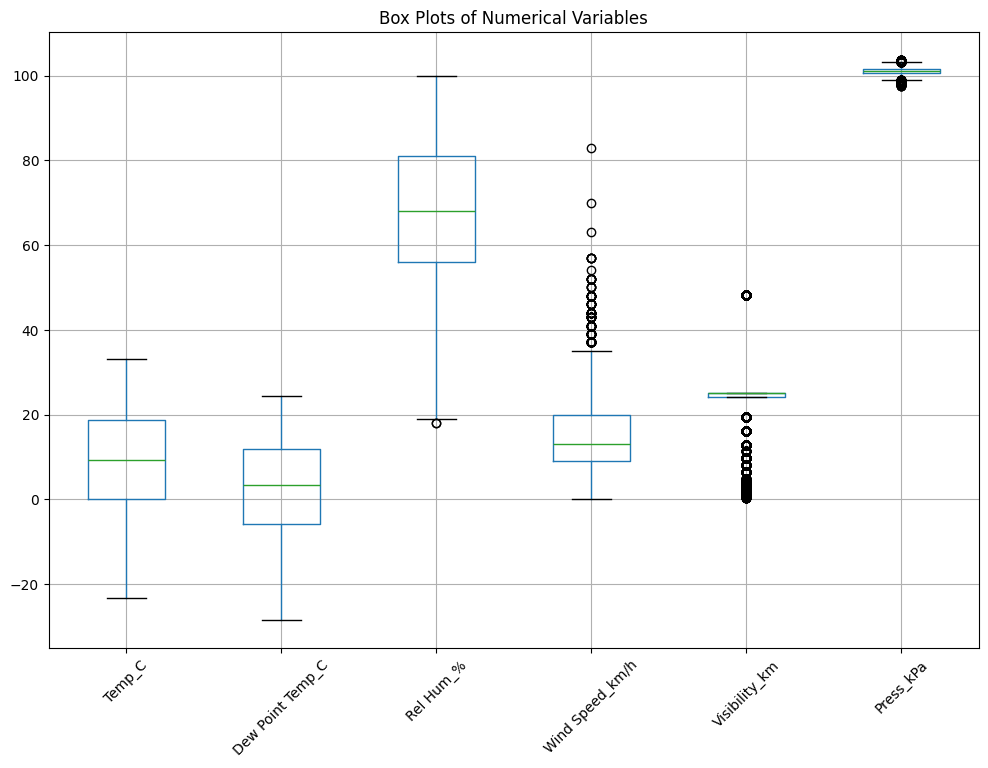

In [4]:
plt.figure(figsize=(12, 8))
dataset[numeric_cols].boxplot()
plt.xticks(rotation=45)
plt.title('Box Plots of Numerical Variables')
plt.show()

In [5]:
def replace_outliers_iqr(df, columns):
    df_replaced = df.copy()
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Replace outliers with boundary values
        df_replaced[col] = np.where(df[col] < lower_bound, lower_bound,
                            np.where(df[col] > upper_bound, upper_bound, df[col]))
    return df_replaced

df_clean = replace_outliers_iqr(dataset.copy(), numeric_cols)
print(f"Original shape: {dataset.shape}, Cleaned shape: {df_clean.shape}")



Original shape: (8784, 8), Cleaned shape: (8784, 8)


Skewness:
 Temp_C             -0.177636
Dew Point Temp_C   -0.318379
Rel Hum_%          -0.323644
Wind Speed_km/h     0.529343
Visibility_km      -0.234396
Press_kPa          -0.096751
dtype: float64


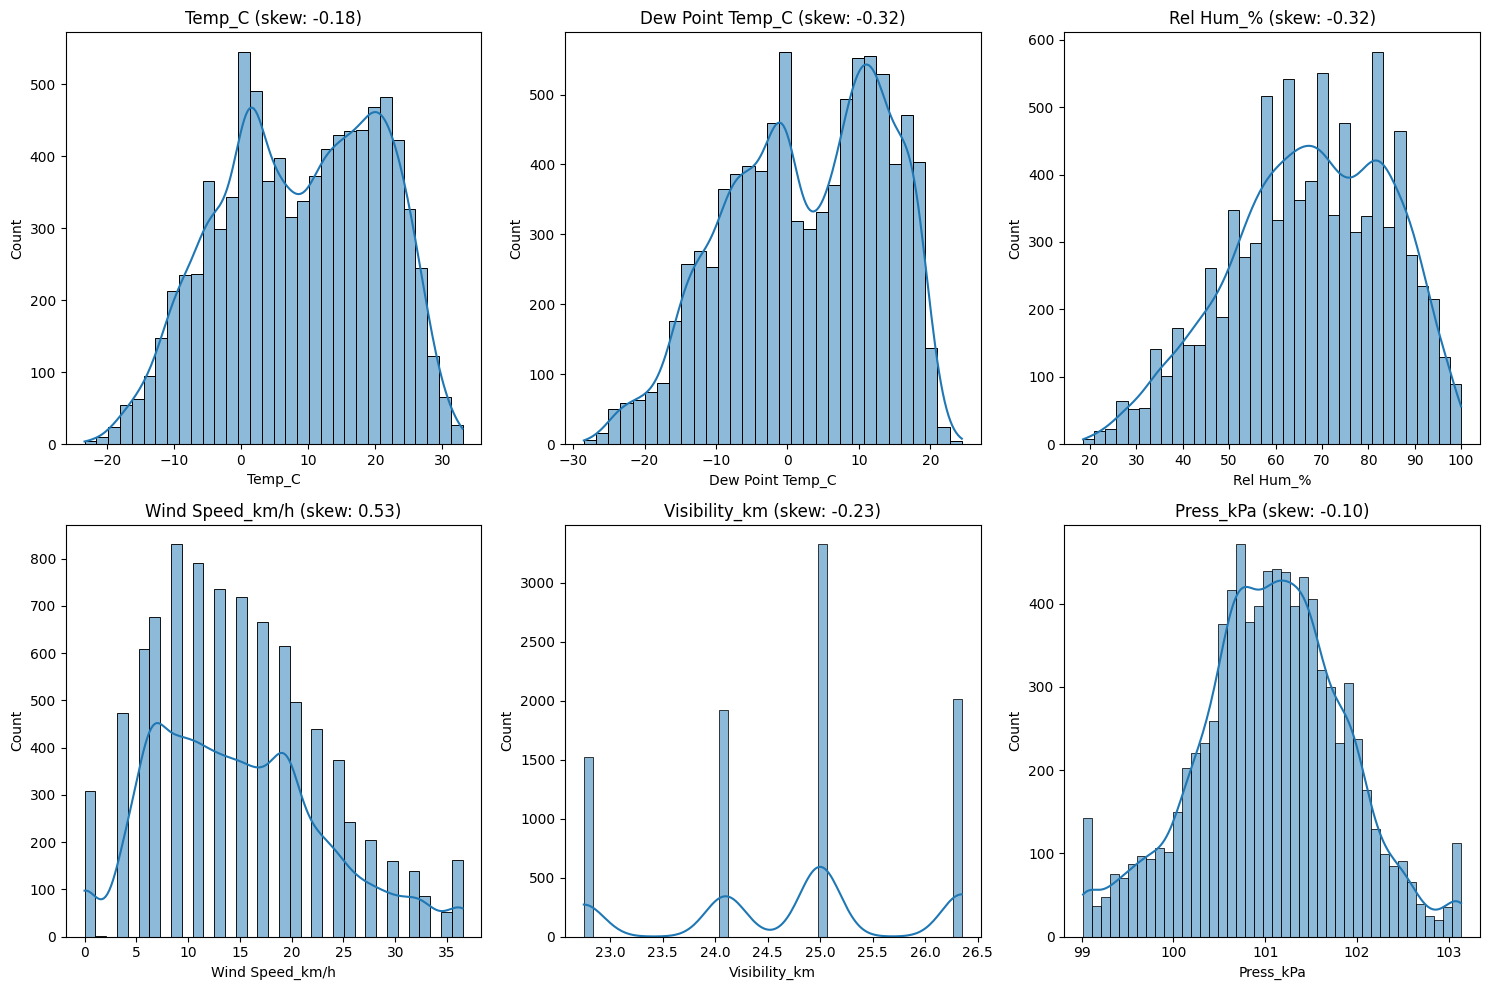

In [6]:
# Check skewness
skewness = df_clean[numeric_cols].apply(lambda x: skew(x.dropna()))
print("Skewness:\n", skewness)

# Plot distributions
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.ravel()
for i, col in enumerate(numeric_cols):
    sns.histplot(df_clean[col], kde=True, ax=axes[i])
    axes[i].set_title(f'{col} (skew: {skewness[col]:.2f})')
plt.tight_layout()
plt.show()

In [7]:
df_transformed = df_clean.copy()

for col in numeric_cols:
    if skewness[col] > 0.5 or skewness[col] < -0.5:  # arbitrary threshold
        # Shift if negative
        if df_transformed[col].min() <= 0:
            shift = -df_transformed[col].min() + 0.001
            data_shifted = df_transformed[col] + shift
        else:
            data_shifted = df_transformed[col]
        # Apply Box-Cox
        transformed_data, _ = boxcox(data_shifted)
        df_transformed[col] = transformed_data

# Check skewness after transformation
skewness_after = df_transformed[numeric_cols].apply(lambda x: skew(x.dropna()))
print("Skewness after transformation:\n", skewness_after)


Skewness after transformation:
 Temp_C             -0.177636
Dew Point Temp_C   -0.318379
Rel Hum_%          -0.323644
Wind Speed_km/h    -0.318100
Visibility_km      -0.234396
Press_kPa          -0.096751
dtype: float64


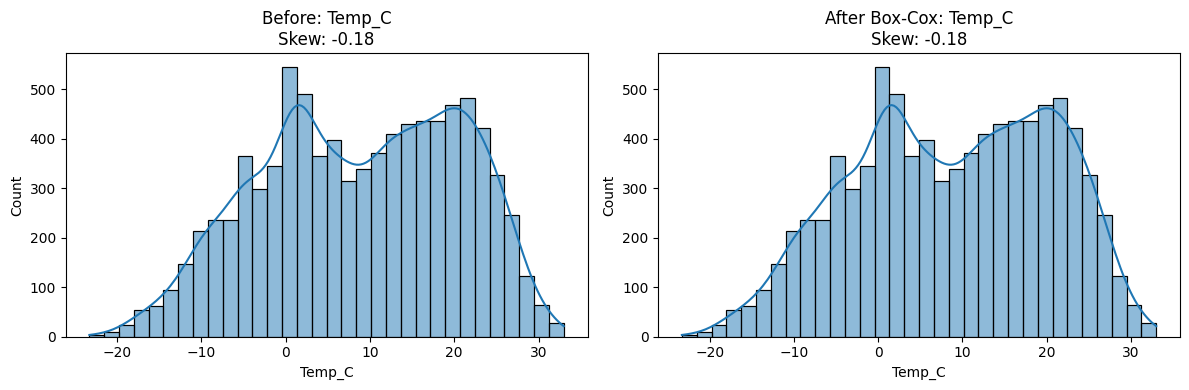

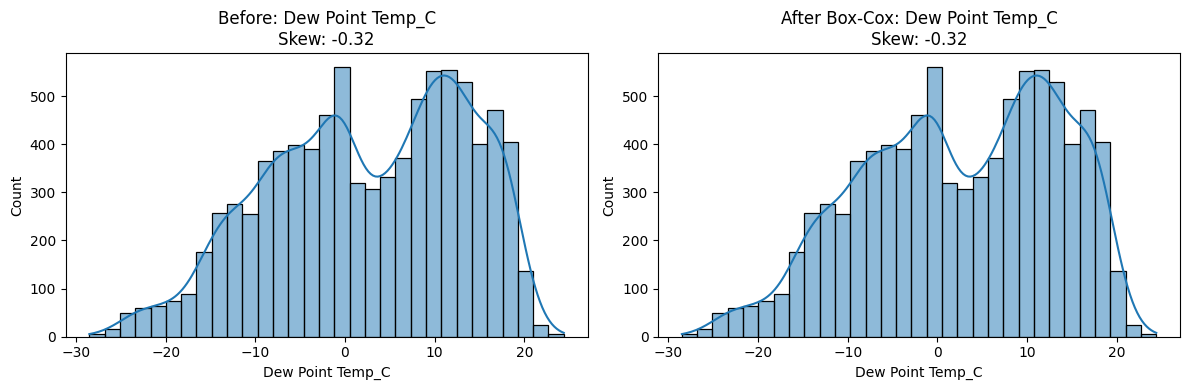

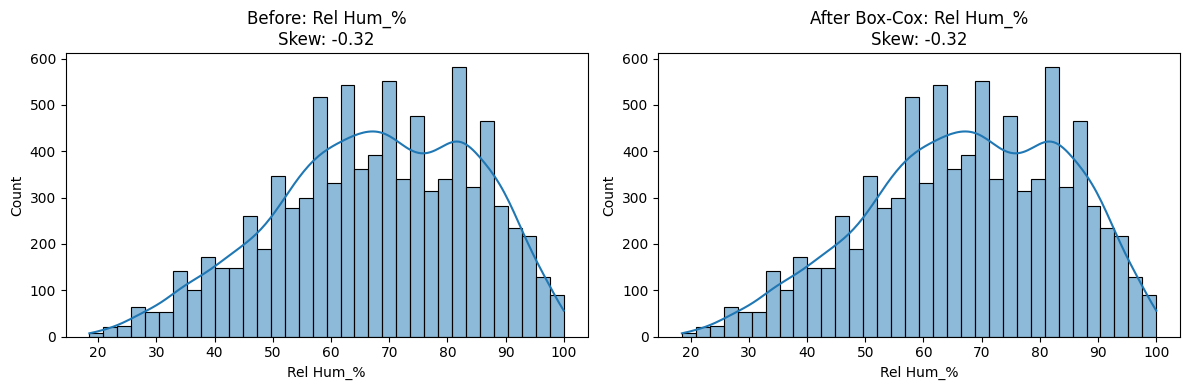

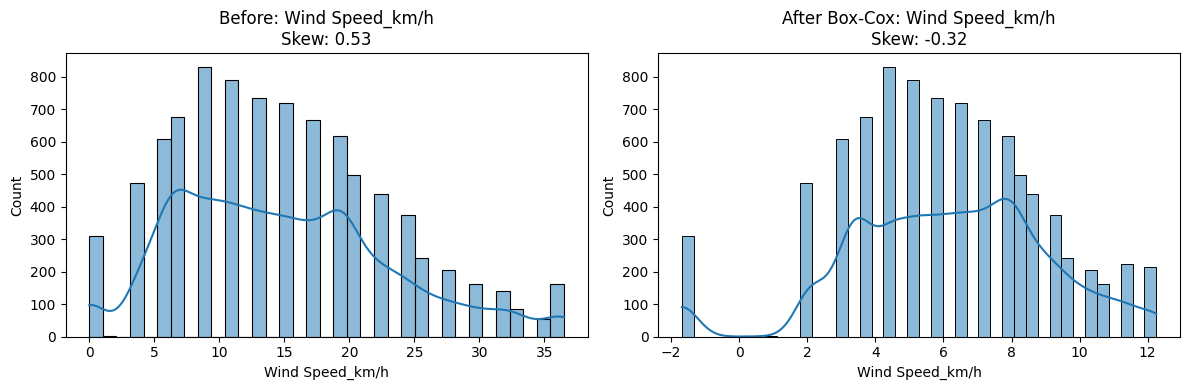

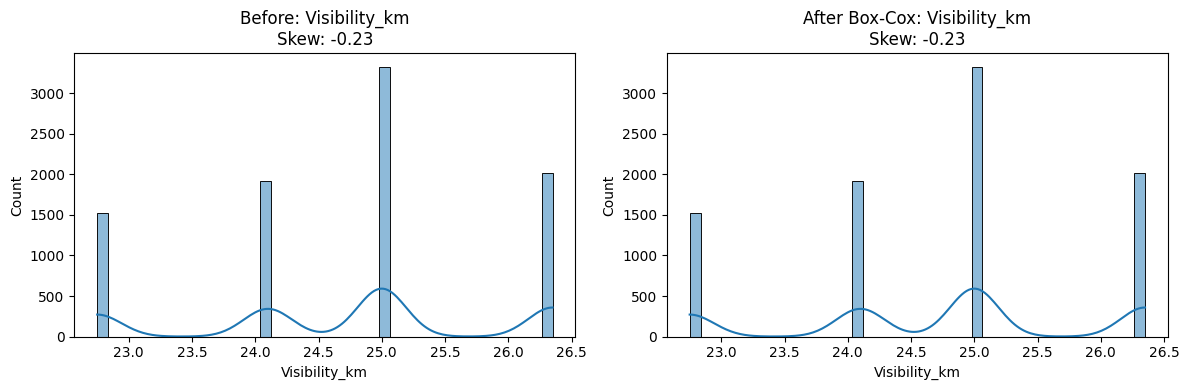

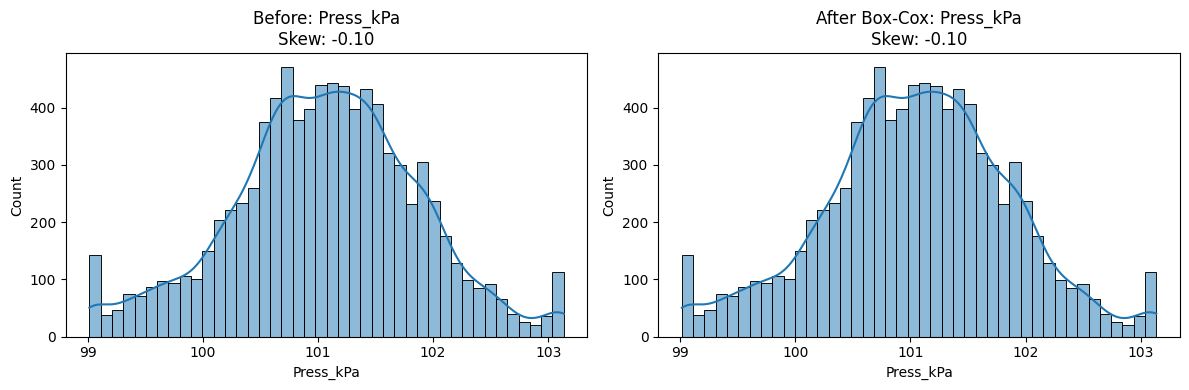

In [8]:
# Plot before and after Box-Cox transformation
for col in numeric_cols:
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    # Before transformation
    sns.histplot(df_clean[col].dropna(), kde=True, ax=axes[0])
    axes[0].set_title(f"Before: {col}\nSkew: {skew(df_clean[col].dropna()):.2f}")

    # After transformation
    sns.histplot(df_transformed[col].dropna(), kde=True, ax=axes[1])
    axes[1].set_title(f"After Box-Cox: {col}\nSkew: {skew(df_transformed[col].dropna()):.2f}")

    plt.tight_layout()
    plt.show()


In [9]:
dataset

,Date/Time,Temp_C,Dew Point Temp_C,Rel Hum_%,Wind Speed_km/h,Visibility_km,Press_kPa,Weather
0,1/1/2012 0:00,-1.8,-3.9,86,4,8.0,101.24,Fog
1,1/1/2012 1:00,-1.8,-3.7,87,4,8.0,101.24,Fog
2,1/1/2012 2:00,-1.8,-3.4,89,7,4.0,101.26,"Freezing Drizzle,Fog"
3,1/1/2012 3:00,-1.5,-3.2,88,6,4.0,101.27,"Freezing Drizzle,Fog"
4,1/1/2012 4:00,-1.5,-3.3,88,7,4.8,101.23,Fog
...,...,...,...,...,...,...,...,...
8779,12/31/2012 19:00,0.1,-2.7,81,30,9.7,100.13,Snow
8780,12/31/2012 20:00,0.2,-2.4,83,24,9.7,100.03,Snow
8781,12/31/2012 21:00,-0.5,-1.5,93,28,4.8,99.95,Snow
8782,12/31/2012 22:00,-0.2,-1.8,89,28,9.7,99.91,Snow


In [10]:
#To decrease the column size of weather
def group_weather(w):
    if "Clear" in w:
        return "Clear"
    elif "Cloudy" in w or "Fog" in w or "Haze" in w:
        return "Cloudy"
    elif "Rain" in w or "Drizzle" in w or "Thunderstorm" in w:
        return "Rain"
    elif "Snow" in w:
        return "Snow"
    else:
        return "Other"
dataset["Weather"] = dataset["Weather"].apply(group_weather)

In [11]:
dataset["Weather"].value_counts()

,count
Weather,
Cloudy,4252
Clear,3432
Rain,618
Snow,482


In [12]:
ind = dataset.drop(['Weather', 'Date/Time'], axis=1)



In [13]:
dep=dataset[["Weather"]]

In [14]:


# Split the data
X_train, X_test, y_train, y_test = train_test_split(ind, dep, test_size=0.2, random_state=42)





In [15]:
# Scale the features
scaler = StandardScaler()
X_train= scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [16]:
# Train KNN model
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

/usr/local/lib/python3.12/dist-packages/sklearn/neighbors/_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


KNeighborsClassifier()

In [17]:
# Make predictions
y_pred = knn.predict(X_test)

In [18]:
from sklearn.metrics import classification_report
cls = classification_report(y_test, y_pred)
print(cls)

              precision    recall  f1-score   support

       Clear       0.64      0.73      0.68       665
      Cloudy       0.67      0.69      0.68       863
        Rain       0.57      0.26      0.36       120
        Snow       0.82      0.50      0.62       109

    accuracy                           0.66      1757
   macro avg       0.68      0.54      0.59      1757
weighted avg       0.66      0.66      0.66      1757



In [19]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
cm = confusion_matrix(y_test, y_pred)

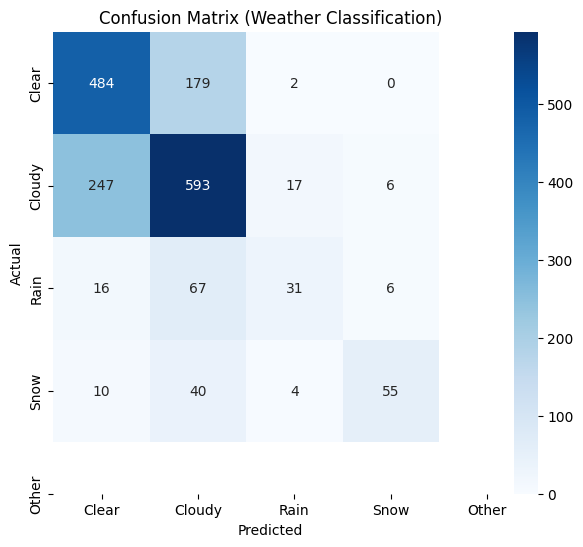

In [20]:
#Visualize
import seaborn as sns
import matplotlib.pyplot as plt
class_names = ['Clear', 'Cloudy', 'Rain', 'Snow', 'Other']

plt.figure(figsize=(7, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Weather Classification)')
plt.show()

In [21]:
import pickle
filename = "KNN_Neighbors.sav"
pickle.dump(knn,open(filename,"wb"))
load_model=pickle.load(open("/content/KNN_Neighbors.sav","rb"))

In [24]:
result=load_model.predict([[-1.5	,-3.3	,88	,7,	4.8	,101.23	]])

In [26]:
result

array(['Clear'], dtype=object)